In [1]:
%matplotlib notebook

## Bragg peak progression values and error bars from several outputs, computed with different values of the peak width parameter

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
mpl.rcParams['font.size'] = 6.
mpl.rcParams['font.family'] = 'serif'

golden_ratio  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good
figWidth = 3.37
mpl.rcParams['figure.figsize'] = figWidth, figWidth * golden_ratio

In [3]:
w_15 = np.array([np.array([ 1.        ,  1.05473332,  1.06578211,  1.1085688 ,  1.08285494,
         1.08639277,  1.17664317]),
 np.array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.]),
 np.array([ 1.        ,  0.94026273,  0.92851886,  0.96696775,  0.93781928,
         0.94920423,  0.95996687])])
w_20 = np.array([np.array([ 1.        ,  1.06777415,  1.11282934,  1.13556469,  1.11867025,
         1.12980238,  1.19486332]),
 np.array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.]),
 np.array([ 1.        ,  0.97015993,  0.91545177,  1.03087026,  0.98397024,
         1.00570189,  1.02754899])])

In [4]:
progressions = [w_15, w_20]
#progressions = [w_20]
mean = np.mean(progressions, axis = 0)
stderr = np.std(progressions, axis = 0)/np.sqrt(len(progressions))
labels = ['111', '200', '222']

In [5]:
fluxes = np.array([ 23080.999908  ,   9472.38824234,   2404.57689574,    447.60799673,
          101.06103334,     58.8079792 ,     30.16713449][::-1])

In [6]:
i0_200_20 = np.array([ 1.        ,  0.87703524,  0.89841387,  0.8849395 ,  0.89060012,
        0.87608614,  0.9418514 ])
i0_200_15 = np.array([ 1.        ,  0.82095889,  0.86219382,  0.82523548,  0.84587632,
        0.85842783,  0.88508954])

In [7]:
i0_200_mean = np.mean([i0_200_20, i0_200_15], axis = 0)
i0_200_stderr = 1.5 * np.std([i0_200_20, i0_200_15], axis = 0)/np.sqrt(len(progressions))

<IPython.core.display.Javascript object>


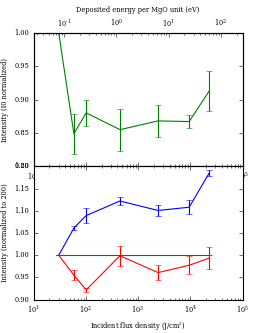

In [8]:
mpl.rcParams['figure.figsize'] = figWidth, figWidth * golden_ratio * 2

fig = plt.figure()

x, y = np.arange(10), np.arange(10)
ax1 = fig.add_subplot(2,1,1)
#ax1.plot(x, y)
ax2 = fig.add_subplot(2,1,2,sharex=ax1)

for curve, err, label in zip(mean, stderr, labels):
    ax2.errorbar(fluxes, curve, yerr=err, label = label)
#ax2.plot(x, y)


ax = fig.add_axes( [0., 0., 1, 1] )
ax.set_axis_off()

#ax.text( 
#    .05, 0.5, "Y Label", rotation='vertical',
#    horizontalalignment='center', verticalalignment='center'
#)



fig.subplots_adjust(hspace=0)

#ax1.xaxis.set_label_position('top')
ax2.semilogx()


ax1.set_ylabel('Intensity (I0 normalized)')
#ax1.get_xaxis().set_visible(False)

xscale = .0026
ax1 = ax1.twiny()
ax1.errorbar(fluxes * xscale, i0_200_mean, yerr=i0_200_stderr, label = label, color = 'g')
ax1.set_xlim((xscale * 1e1, xscale * 1e5))
ax1.semilogx()

ax1.set_xlabel('Deposited energy per MgO unit (eV)')
#ax1.text( 
#    .1, 0.1, "(a)"
#)
ax2.set_xlabel('Incident flux density (J/cm$^2$)')

#y2a = ax2.axes.get_yaxis()
#ticks = y2a.get_ticklabels()
#y2a.set_ticklabels([str(t) for t in ticks])

ax2.set_ylabel('Intensity (normalized to 200)')



In [8]:
scfly_intensities, scfly_ratios = np.genfromtxt('scfly_progression.dat')
vasp_intensities, vasp_ratios = np.genfromtxt('vasp_progression.dat')
vasp_ratios = vasp_ratios[vasp_intensities > 10]
vasp_intensities = vasp_intensities[vasp_intensities > 10]
scfly_vasp_intensities, scfly_vasp_ratios = np.genfromtxt('scfly_vasp_progression.dat')

### AFF model, assuming all XFEL energy goes to O 2p ionization, with a 7.8 eV needed per ionized electron

In [9]:
avogadro = 6.022 * 10**23
to_ev = 6.24e18
peratom = lambda I, mu, M, rho: I * M / (mu * rho * avogadro)
to_ev * 2.4e-17

def flux_to_ev(flux):
    return peratom(flux, .015, 40.3, 3.6) * to_ev

def ev_to_flux(ev):
    return ev / (peratom(1., .015, 40.3, 3.6) * to_ev)

bandgap = 7.8

In [10]:
dat =  np.genfromtxt('MgO_O2p.txt')
x, i111, i200, i220 = dat[:4]
labels  = ['111', '200', '220']

from scipy.interpolate import interp1d
aff_bandgap_intensities = ev_to_flux((6/100) * x * bandgap)
aff_bandgap_interp = interp1d(aff_bandgap_intensities, i111)
#aff_bandgap_intensities[0] = .1

### Same thing, using 1.5 eV (O electron affinity) instead of the band gap

Note:
* 1st EA: -1.42 kJ/mol
* 2nd EA: +844 kJ/mol

In [11]:
Oea = 1.
aff_ea_intensities = ev_to_flux((6/100) * x * Oea)
aff_ea_interp = interp1d(aff_ea_intensities, i111)

In [12]:
pulseavg_factor = 1.9

In [34]:
def shiftx(x, y, factor):
    new_y_interp = interp1d(x * factor, y)
    mask = np.logical_and(min(x * factor) < x, x < max(x * factor))
    newx = x[mask]
    return mask, new_y_interp(newx)

In [24]:
scfly_intensities

array([ 19933.65 ,  13085.55 ,   8590.5  ,   5639.4  ,   3702.06 ,
         2430.315,   1595.43 ,   1047.33 ,    687.555,    451.35 ])

In [61]:
a = np.arange(10)

In [62]:
np.pad(a, 2, '')

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [67]:
def plot_and_shade_right(x, y, color, factor = 3., label = '',):
    i = np.argsort(x)
    x = x[i]
    y = y[i]
    mask, shifted = shiftx(x, y, factor)
    ax2.plot(x, y, color= color)
    fill_x = x[~mask]
    fill_y = np.repeat(min(shifted), len(fill_x))
    newy = np.concatenate((fill_y, shifted))
    
    ax2.fill_between(x, y, newy, alpha = 0.5, label = label, color = color)

<IPython.core.display.Javascript object>


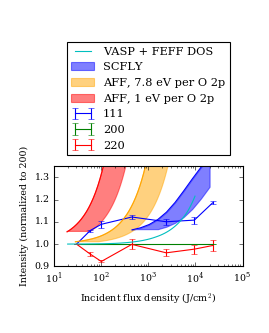

In [80]:
mpl.rcParams['figure.figsize'] = figWidth, figWidth * golden_ratio * 2
mpl.rcParams['font.size'] = 8.5

#plt.tight_layout()

fig = plt.figure()

x, y = np.arange(10), np.arange(10)
ax2 = fig.add_subplot(1,1,1)
plt.gcf().subplots_adjust(bottom=0.2, left = 0.2, top = 0.5)

for curve, err, label in zip(mean, stderr, labels):
    ax2.errorbar(fluxes, curve, yerr=err, label = label)

#ax2.plot(scfly_intensities, scfly_ratios, label = 'SCFLY')
#ax2.plot(scfly_intensities * 3, scfly_ratios, label = 'SCFLY 111 (shifted x3)')

plot_and_shade_right(scfly_intensities, scfly_ratios, 'blue', factor = 3., label = 'SCFLY')

#ax2.plot(np.arange(15, 3000, 1) * pulseavg_factor, aff_bandgap_interp(np.arange(15, 3000, 1)),
#         label = 'AFF, 7.8 eV per O 2p')
plot_and_shade_right(np.arange(15, 3000, 1) * pulseavg_factor, aff_bandgap_interp(np.arange(15, 3000, 1)),
         'orange', label = 'AFF, 7.8 eV per O 2p')

#ax2.plot(np.arange(15, 700, 1) * pulseavg_factor, aff_ea_interp(np.arange(15, 700, 1)),
#         label = 'AFF, 1 eV per O 2p')
plot_and_shade_right(np.arange(10, 750, 1) * pulseavg_factor, aff_ea_interp(np.arange(10, 750, 1)), 'red', label = 'AFF, 1 eV per O 2p')

#ax2.plot(np.arange(15, 700, 1) * pulseavg_factor * 3, aff_ea_interp(np.arange(15, 700, 1)),
#         label = 'AFF, 1 eV per O 2p (shifted x3)')

# already account for pulse averaging in MgO_VASP
ax2.plot(vasp_intensities, vasp_ratios, label = 'VASP + FEFF DOS')

#ax2.plot(vasp_intensities * 5, vasp_ratios, label = 'VASP (DOS) (shifted x5)')
#ax2.plot(scfly_vasp_intensities, scfly_vasp_ratios, label = 'VASP (SCFLY T)')

ax = fig.add_axes( [0., 0., 1, 1] )
ax.set_axis_off()

ax2.set_ylim((0.9, 1.35))

fig.subplots_adjust(hspace=0)

ax2.semilogx()

xscale = .0026

ax2.set_xlabel('Incident flux density (J/cm$^2$)')
ax2.set_ylabel('Intensity (normalized to 200)')

handles, labelsrev = ax2.get_legend_handles_labels()

#handles = [h[0] for h in handles]
leg = ax2.legend(handles, labelsrev, loc='upper center', ncol = 1,
               bbox_to_anchor = (0.5, 2.3))#, numpoints=1)


In [82]:
fig.savefig('experimental_vs_scfly_vasp_exciton_shaded.png', dpi = 300, bbox_inches='tight')

### Model prediction

### LTE model:

<IPython.core.display.Javascript object>


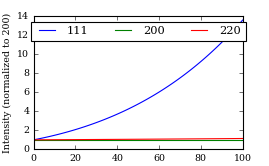

<IPython.core.display.Javascript object>


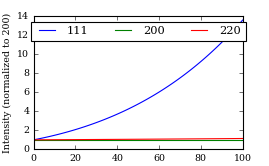

In [21]:
def plot_lte(dat, lcoords = (0.5, 1.)):
    x, i111, i200, i220 = dat[:4]
    labels  = ['111', '200', '220']

    mpl.rcParams['figure.figsize'] = figWidth, figWidth * golden_ratio

    # First illustrate basic pyplot interface, using defaults where possible.
    fig  = plt.figure()

    for curve, label in zip([i111, i200, i220], labels):
        plt.plot(x, curve, label = label)

    #plt.semilogx()
    #plt.ylim((0.9, 1.25))
    # remove the errorbars from the legend
    ax = fig.axes[0]
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Ionization fraction (percent)')
    plt.ylabel('Intensity (normalized to 200)')
    
    handles = [h for h in handles]
    leg = ax.legend(handles, labels, loc='upper center', ncol = 3,
               bbox_to_anchor = lcoords)#, numpoints=1)
    return fig

dat =  np.genfromtxt('MgO_O2p.txt')
plot_lte(dat)


In [183]:
d = np.genfromtxt('MgO_simultaneous_r0.75.dat')

In [223]:
x = d[0][::2]
i111 = d[0][1::2]
i200 = d[1][1::2]
i220 = d[2][1::2]

<IPython.core.display.Javascript object>


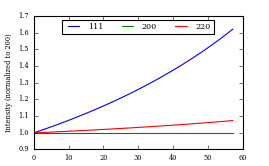

In [224]:
fig = plot_lte([x, i111, i200, i220], lcoords = (0.5, 1.))

In [220]:
fig.savefig('model2.png', dpi = 300, bbox_inches='tight')

In [201]:
plt.plot(i111)
plt.show()

In [180]:
!mv MgO_simultaneous_r0.75\ \(1\).dat MgO_simultaneous_r0.75.dat

In [182]:
pd.read_csv('MgO_simultaneous_r0.75.dat');

<IPython.core.display.Javascript object>


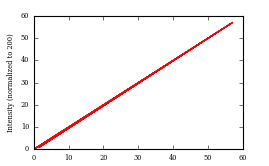

In [199]:
plot_lte('MgO_simultaneous_r0.75.dat')

In [ ]:
plot_lte('')

In [161]:
fig.savefig('prediction.png', dpi = 300, bbox_inches='tight')

In [3]:
import pandas as pd
import cufflinks
import plotly.plotly as py
py.sign_in('revilo222', 'qnGBeolE0CtdzjEajfql')